# Exploring stative and active verbs

This notebook explores quantitative methods for determining the inherent situational aspect (stative/active) of Hebrew verbs in a reduced corpus (Genesis - Kings).

In [1]:
#Dataset path
PATH = 'datasets/'

import os
import collections
import pandas as pd
import numpy as np

#Plots
import matplotlib.pyplot as plt

#Display
from IPython.display import display, clear_output
import Logos

In [2]:
from tf.app import use
A = use('bhsa', hoist=globals(), mod='etcbc/heads/tf')

Using TF-app in C:\Users\Ejer/text-fabric-data/annotation/app-bhsa/code:
	rv2.2.0=#b3757bf25f7b165f75cd02fc3c8f501f84b97935 offline under ~/text-fabric-data (local release)
Using data in C:\Users\Ejer/text-fabric-data/etcbc/bhsa/tf/c:
	rv1.6=#bac4a9f5a2bbdede96ba6caea45e762fe88f88c5 offline under ~/text-fabric-data (local release)
Using data in C:\Users\Ejer/text-fabric-data/etcbc/phono/tf/c:
	r1.2=#1ac68e976ee4a7f23eb6bb4c6f401a033d0ec169 offline under ~/text-fabric-data (local release)
Using data in C:\Users\Ejer/text-fabric-data/etcbc/parallels/tf/c:
	r1.2=#395dfe2cb69c261862fab9f0289e594a52121d5c offline under ~/text-fabric-data (local release)
Using data in C:\Users\Ejer/text-fabric-data/etcbc/heads/tf/c:
	rv.1.3.1=#6efbd7adb3ccfd3d4dcd780f76c5f86672395eb8 offline under ~/text-fabric-data (local release)
   |     0.01s Dataset without structure sections in otext:no structure functions in the T-API


In [5]:
query = '''
book book=Leviticus
  chapter chapter=17|18|19|20|21|22|23|24|25|26
    phrase function=Pred|PreO|PreS
      word sp=verb
'''
results = A.search(query)

  1.25s 882 results


In [7]:
verbs = []

for r in results:
    verbs.append(F.lex.v(r[3]))

In [9]:
len(set(verbs))

175

### Basic functions

In [3]:
def simple_bar(dic, sort=True, heb=False):    
    df = pd.DataFrame([dic]).T
    if sort:
        df = df.sort_values(by=0, ascending=False)
    
    plt.bar(x=df.index, height=df.loc[:,0])
    
    if heb:
        new_xticks = [f"{reverse_hb(l[:l.index('_')])} {l[l.index('_')+1:]}" for l in list(df.index)]
        plt.xticks(df.index, new_xticks, rotation=30, ha='right', rotation_mode="anchor", size=12)
    
    plt.yticks(size=12)
    plt.show()
    
def reverse_hb(hb_text):
    return ''.join(reversed(hb_text))

### Preparing corpus

In [4]:
# prepare the corpus

corpus = [book for book in F.otype.s('book') if book < T.nodeFromSection(('Isaiah',))]
print('Corpus:\n')
print('\n'.join(T.sectionFromNode(book)[0] for book in corpus))

Corpus:

Genesis
Exodus
Leviticus
Numbers
Deuteronomy
Joshua
Judges
1_Samuel
2_Samuel
1_Kings
2_Kings


In [5]:
sets={'corpus':corpus} # make set for searching

Phrases to consider:

In [6]:
phrases = 'Pred'

## Overall statistics

We will explore *Qal* verbs and their collocations with certain complements.

In [7]:
Qal = '''
corpus
 clause
  phrase function={}
    word vs=qal pdp=verb lex#HJH[
'''

unique_verbs = set()

for r in A.search(Qal.format(phrases), sets=sets, silent=True):
    unique_verbs.add(F.lex.v(r[3]))
    
print(f'Number of verbs in Qal and functioning as predicate: {len(unique_verbs)}')

Number of verbs in Qal and functioning as predicate: 616


How many Qal-verbs with only one complement and no object?

In [8]:
Qal_cmpl = '''
corpus
 clause
 /without/
   phrase function=Objc
 /-/
 /without/
  phrase function=Cmpl
  > phrase function=Cmpl
 /-/
  phrase function={}
    word vs=qal pdp=verb lex#HJH[
  phrase function=Cmpl
'''

unique_verbs_cmpl = set()

for r in A.search(Qal_cmpl.format(phrases), sets=sets, silent=True):
    unique_verbs_cmpl.add(F.lex.v(r[3]))
    
print(f'Number of verbs in Qal with complement: {len(unique_verbs_cmpl)}')

Number of verbs in Qal with complement: 333


That is, 283 verb lexemes are not accounted for by this analysis. Those lexemes may have other significant modifiers, such as time and locative phrases. 

In [9]:
len(unique_verbs)-len(unique_verbs_cmpl)

283

## Breaking down complements phrases:

In [10]:
complements = '''
corpus
  clause
  /without/
    phrase function=Objc
  /-/
  /without/
    phrase function=Cmpl
    > phrase function=Cmpl
  /-/
    phrase function={}
      word vs=qal pdp=verb lex#HJH[
    phrase function=Cmpl
'''
complements = A.search(complements.format(phrases), sets=sets)

  3.42s 6403 results


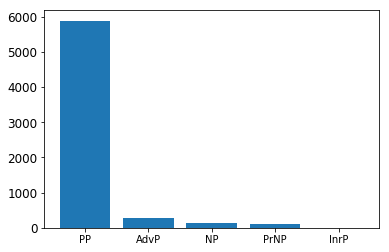

In [11]:
complement_types = collections.defaultdict(int)

for r in complements:
    complement_types[F.typ.v(r[4])] += 1
    
simple_bar(complement_types)

In [12]:
complement_types

defaultdict(int, {'PP': 5882, 'NP': 126, 'AdvP': 269, 'InrP': 7, 'PrNP': 119})

### Zooming in on Prepositional Phrases

In [13]:
PP  = '''
corpus
  clause
  /without/
    phrase function=Objc
  /-/
  /without/
    phrase function=Cmpl
    > phrase function=Cmpl
  /-/
    phrase function=Cmpl typ=PP
    phrase function={}
      word vs=qal pdp=verb lex#HJH[
'''

PP = A.search(PP.format(phrases), sets=sets)

  3.67s 5882 results


In [14]:
PP_sp = collections.defaultdict(int)

for r in PP:
    head = E.head.t(r[2])[0]
    PP_sp[F.sp.v(head)] += 1

PP_sp

defaultdict(int, {'prep': 5657, 'subs': 225})

Prepositions:

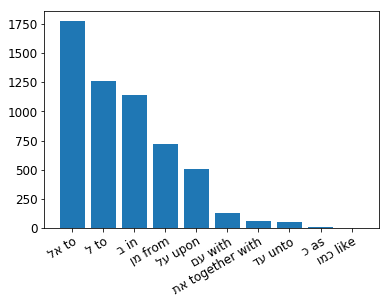

In [15]:
prep_dict = collections.defaultdict(int)

for r in PP:
    head = E.head.t(r[2])[0]
    if F.sp.v(head) == 'prep':
        prep_dict[f'{F.lex_utf8.v(head)}_{F.gloss.v(L.u(head, "lex")[0])}'] += 1
                  
simple_bar(prep_dict, heb=True)

### Exploring prepositions

We will explore the prepositions in some depth, because the prepositions are polysemous and can be used in many different functions. We select the complement types that are most likely to be directional or locational. Secondly, these complement phrases are manually checked to discard other uses of the complement phrase.

The following query is the default query to explore the prepositions one by one:

In [16]:
query = '''
corpus
  clause
  /without/
    phrase function=Objc
  /-/
  /without/
    phrase function=Cmpl
    > phrase function=Cmpl
  /-/
    phrase function=Cmpl
      =: word lex={}
    phrase function={}
      word vs=qal pdp=verb lex#HJH[
'''

### ל

ל is used in a great variety of ways. One of the basic senses is locative (cf. BHRG §11.2.10b), but the preposition may mark either position or direction, depending on the verb, making, in effect, the preposition very versatile. For that reason, the preposition is not a good indicator as to whether the verb is stative or active.

In [17]:
L_prep = A.search(query.format('L',phrases), sets=sets)
A.show(L_prep, end=1)

  5.48s 1258 results


### אל

אל is used for a varity of expressions, typically denoting either direction or dative, e.g. recipient or addressee, but also ethical dative and comitative (cf. BHRG §11.2.2a). We will take a look at those nouns governed by the preposition to sort isolate directional and locational senses:

In [18]:
EL_prep = A.search(query.format('>L',phrases), sets=sets)
A.show(EL_prep, end=1)

  5.39s 1769 results


###  ב

The prepositions ב is used both as locative ("in", "by", "at"), but also as instrument ("with"). To distinguish these senses, we take a closer look at the nouns governed by the preposition:

In [23]:
B_prep = A.search(query.format('B', phrases), sets=sets)
A.show(B_prep, start=1000, end=1005)

  4.53s 1131 results


### מן

מן has both a spatial, a partial, and a comparative sense. Even the spatial sense is not easy to distinguish because it can refer to the origin of a movement or the direction where a thing is located (cf. BHRG, §11.2.11b). Therefore, we skip this preposition in the present analysis.

In [20]:
MN_prep = A.search(query.format('MN', phrases), sets=sets)

  3.81s 720 results


### על

The most commen sense of על is the spatial "on" or "over" (cf. BHRG §11.2.13b). Apart from this locative sense, על may less frequently be used as the goal of a movement. The preposition can also be used as denoting opposition ("against") or as marking a topic ("concerning"). As before, we will take a look at the nouns governed by the preposition: 

In [21]:
AL_prep = A.search(query.format('<L', phrases), sets=sets)

  3.83s 505 results


### Final ה

The final-H construction is generally considered a construction of direction, e.g.: "... in coming to Gerah" or "... in direction of Gerah" (Gen 10:19):

In [22]:
final_h = '''
corpus
  clause
  /without/
    phrase function=Objc
  /-/
  /without/
    phrase function=Cmpl
    > phrase function=Cmpl
  /-/
    phrase function=Cmpl
      word uvf=H
    phrase function={}
      word vs=qal pdp=verb lex#HJH[
'''

final_h = A.search(final_h.format(phrases), sets=sets)
A.show(final_h, start=30, end=35)

  3.71s 234 results


### Summing up

Moreover, we have chosen only to work with constructions occuring at least five times for each preposition. This restriction, along with the stoplist, reduces the relevant cases significantly:

In [59]:
constructions = [L_prep, EL_prep, B_prep, MN_prep, AL_prep, final_h]

cases = sum([len(c) for c in constructions])
cases

5617

The number of verbs considered:

In [60]:
verbs = set()

for c in constructions:
    for r in c:
        verbs.add(F.lex.v(r[5]))
        
len(verbs)

317

### Export

Finally, we export the resulting dataset for manual inspection of all cases:

In [61]:
clause_dict = collections.defaultdict()

for c in constructions:
    for r in c:
        clause = r[1]
        verb = F.lex.v(r[5])
        cmpl = r[2]
        
        if F.uvf.v(r[3]) == 'H':
            cmpl_type = 'final_h'
        else:
            cmpl_type = F.lex.v(r[3])

        clause_dict[clause] = [clause, verb, cmpl, cmpl_type]
        
data = pd.DataFrame(clause_dict).T
data.columns = ['clause','verb','phrase','cmpl_type']

data.head()

,clause,verb,phrase,cmpl_type
427656,427656,>MR[,651855,L
427808,427808,>MR[,652310,L
427826,427826,>MR[,652355,L
427844,427844,>MR[,652408,L
427845,427845,CM<[,652412,L


In [62]:
data.to_csv(f'{PATH}corpus_analysis_loc_dir.csv')